In [1]:
!pip install control

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.6/549.6 kB 11.1 MB/s eta 0:00:00


# Problema 1


### Punto a

#### Determinación del orden

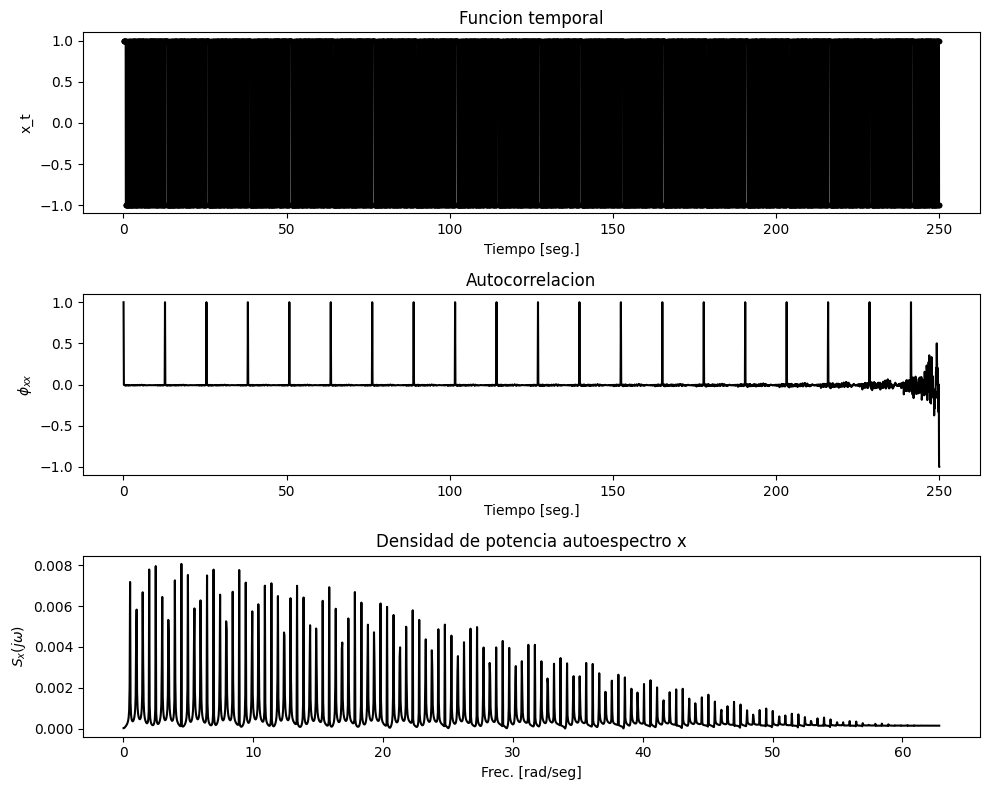

In [673]:
import numpy as np
import control as ctrl
from scipy.signal import dlti, dstep
import matplotlib.pyplot as plt

np.random.seed(10)

# Definición de la función de transferencia
den = [1,3,6]
num = [2,-1]

sys_c = ctrl.TransferFunction(num, den)
# Discretización del sistema
ts = 1/20  # Tasa de muestreo
sys_d = ctrl.sample_system(sys_c, ts, method='zoh')
num_d = sys_d.num[0][0]
den_d = sys_d.den[0][0]
num_d = [0] + num_d  # Asegurar formato correcto

# Generación de PRBS
N = 5000
m = 7
e1, e2 = 6, m
x_seq = np.ones(m)
y = np.zeros(N)
el = 2
for k in range(0, N, el):
    n_b = np.bitwise_xor(int(x_seq[e2 - 1]), int(x_seq[e1 - 1]))
    y[k:k+el] = x_seq[6]
    x_seq[1:] = x_seq[:-1]
    x_seq[0] = n_b

x = 2 * y - 1

y = np.zeros_like(x)
Orn = len(den_d)
num_Orn = len(num_d) # order del numerador

for n in range(Orn, len(x)):
    y[n] = (np.dot(num_d[1:num_Orn], x[n-num_Orn+1:n][::-1]).T -
                np.dot(den_d[1:Orn], y[n-Orn+1:n][::-1])).T

Tmax = N * ts
t = np.arange(ts, Tmax + ts, ts)
W = N / (2 * Tmax)
fmax = 1 / (2 * ts)
Af = 2 * fmax / N
w1 = np.arange(0, fmax, Af)
w = 2 * np.pi * Af
# Autocorrelación de x
fixx = np.zeros(N)
fixx[0] = np.dot(x, x) / N

for j in range(1, N):
    fixx[j] = np.dot(x[:N-j], x[j:N]) / (N - j)

# Correlación cruzada xy
fixy = np.zeros(N)
fixy[0] = np.dot(x, y) / N

for j in range(1, N):
    fixy[j] = np.dot(x[:N-j], y[j:N]) / (N - j)
# Cálculo de la densidad espectral de potencia
M1 = int(0.7 * N)  # Intervalos de correlación útiles
j1 = np.arange(M1)
Sx = np.zeros(M1+1, dtype=complex)

Sx[0] = np.dot(fixx[:M1], np.exp(-1j * 2 * np.pi * 0 * j1 / M1))

for k in range(1, M1+1):
    Sx[k] = np.dot(fixx[:M1], np.exp(-1j * 2 * np.pi * k * j1 / M1))

Sx /= M1
Af = 2 * fmax / M1
w0 = np.arange(Af, fmax + Af, Af)
w0 = 2 * np.pi * w0

# Gráficos
plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
plt.plot(t[:len(x)], x, '.-k')
plt.title('Funcion temporal')
plt.xlabel('Tiempo [seg.]')
plt.ylabel('x_t')

plt.subplot(3, 1, 2)
plt.plot(t[:len(fixx)], fixx, 'k')
plt.title('Autocorrelacion')
plt.xlabel('Tiempo [seg.]')
plt.ylabel(r'$\phi_{xx}$')

plt.subplot(3, 1, 3)
plt.plot(w0[:M1//2], np.abs(Sx[:M1//2]), 'k')
plt.title('Densidad de potencia autoespectro x')
plt.xlabel('Frec. [rad/seg]')
plt.ylabel(r'$S_x(j\omega)$')
plt.tight_layout()
plt.show()

# Cálculo del interespéctro
Sxy = np.zeros(M1+1, dtype=complex)
Sxy[0] = np.dot(fixy[:M1], np.exp(-1j * np.pi * 0 * j1 / M1))

for k in range(1, M1+1):
    Sxy[k] = np.dot(fixy[:M1], np.exp(-1j * 2 * np.pi * k * j1 / M1))

Sxy /= M1


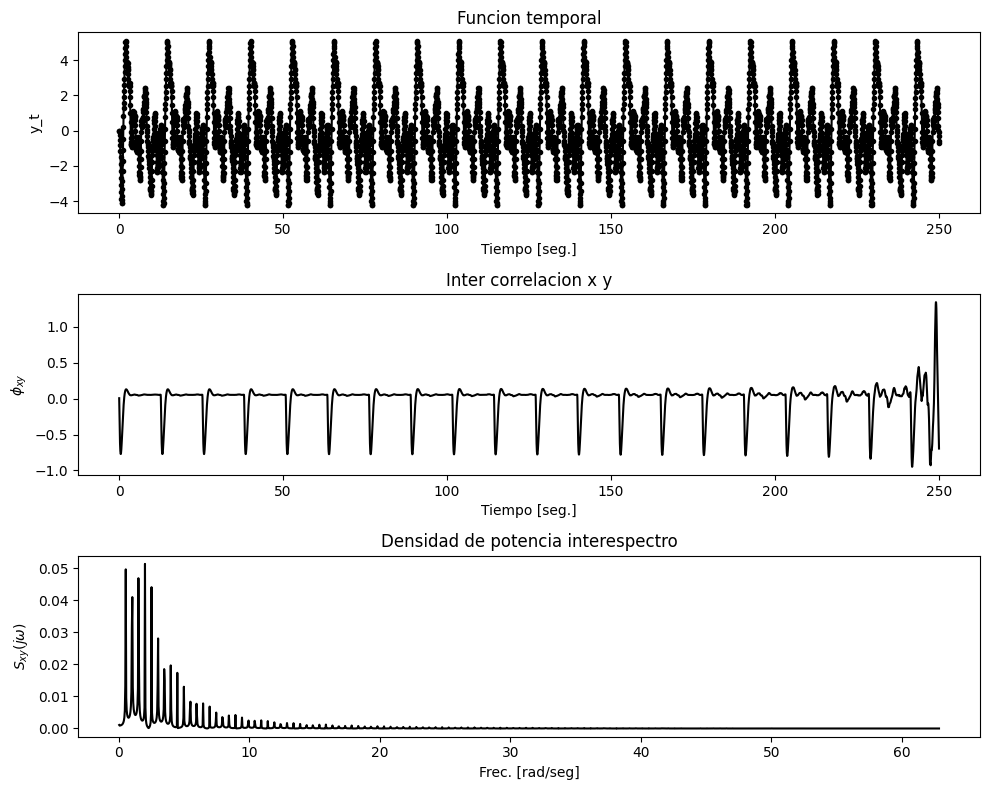

In [674]:
# Gráficos adicionales
plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
plt.plot(t[:len(y)], y, '.-k')
plt.title('Funcion temporal')
plt.xlabel('Tiempo [seg.]')
plt.ylabel('y_t')

plt.subplot(3, 1, 2)
plt.plot(t[:len(fixy)], fixy, 'k')
plt.title('Inter correlacion x y')
plt.xlabel('Tiempo [seg.]')
plt.ylabel(r'$\phi_{xy}$')

plt.subplot(3, 1, 3)
plt.plot(w0[:M1//2], np.abs(Sxy[:M1//2]), 'k')
plt.title('Densidad de potencia interespectro')
plt.xlabel('Frec. [rad/seg]')
plt.ylabel(r'$S_{xy}(j\omega)$')
plt.tight_layout()
plt.show()

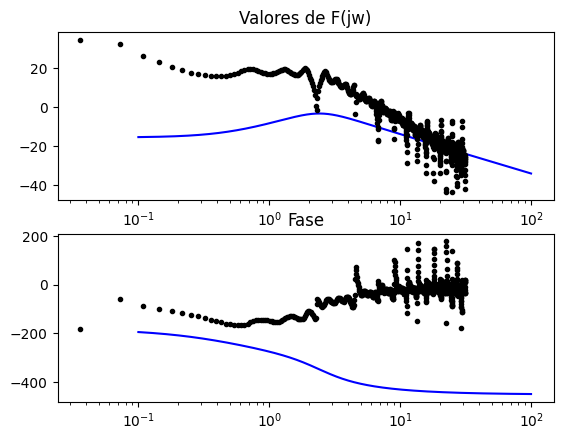

In [675]:
from control import tf, c2d, bode

# Define F_jw
F_jw = Sxy / Sx

# Bode y comparación
mag, phase, omega = bode(sys_c, omega_limits=[1e-1, 1e2], plot=False)
plt.figure()
plt.subplot(2, 1, 1)
plt.semilogx(omega, 20 * np.log10(mag), 'b')
plt.semilogx(w0[:M1//4], 20 * np.log10(np.abs(F_jw[:M1//4])), '.k')
plt.title('Valores de F(jw)')
plt.subplot(2, 1, 2)
plt.semilogx(omega, phase*180/np.pi, 'b')
plt.semilogx(w0[:M1//4], -180 * np.angle(F_jw[:M1//4]) / np.pi, '.k')
plt.title('Fase')
plt.savefig('Fig_20_4_3.png')

#### Identificación

In [676]:
import numpy as np
import scipy.signal as signal
import control as ctrl
import matplotlib.pyplot as plt
from scipy.signal import dlti, dlsim, cont2discrete


# Configuración inicial
np.random.seed(10)
Med = 2500
ts = 1/20
orden_a = 2
orden_b = 1
num = [1]

t = np.arange(0, 20000 * ts, ts)
StepAmplitude = 1

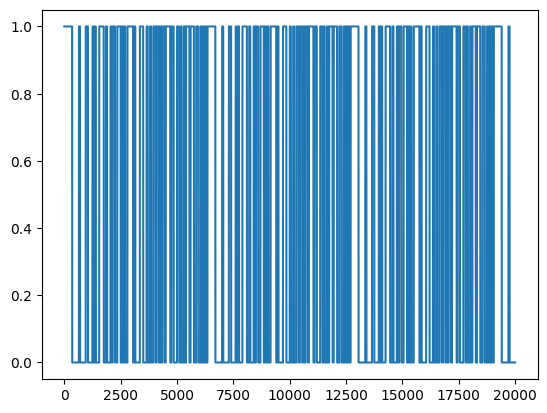

In [677]:
# Generación de PRBS
m = 7
x = np.ones(m)
N = len(t)
el = 50
y = np.zeros(N)
for k in range(0, N, el):
    n_b = np.logical_xor(x[6], x[5])
    y[k:k+el] = x[6]
    x[1:m] = x[:m-1]
    x[0] = n_b
ue = y[:N]
plt.figure()
plt.plot(ue)

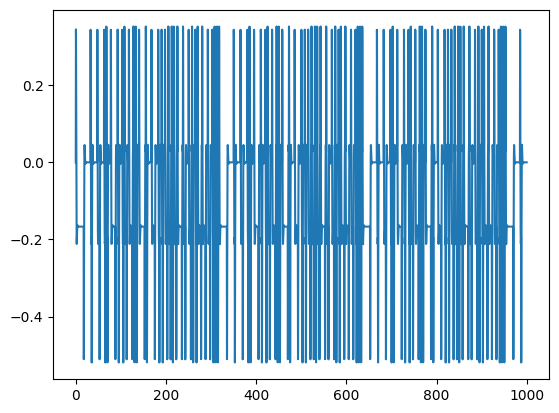

In [678]:
# Definición de la planta
num = [2,-1]
den = [1,3,6]
sys = ctrl.TransferFunction(num, den)

t_out, y_D = ctrl.forced_response(sys, T=t, U=ue)
plt.figure()
plt.plot(t_out, y_D)

In [679]:
ys = y_D.T
# Ajuste por mínimos cuadrados
off_set = orden_a  + 1 + 50
u = ue[off_set:off_set+Med].T
z = ys[off_set:off_set+Med].T
zi = z.copy()

H = np.zeros((Med - orden_a, orden_a + orden_b))
for jj in range(orden_a, Med):
    vec_a = np.fliplr(np.array([np.concatenate([u[jj-orden_b:jj], -z[jj-orden_a:jj]])]))
    H[jj - orden_a, :] = vec_a.reshape(-1)

Z = z[orden_a:]
in_1 = H.T
in_2 = np.dot(in_1, H)
in_3 = np.linalg.inv(in_2)
in_4 = np.dot(in_3, in_1)
c = np.dot(in_4, Z)  # Equation 131
c

array([-1.91640778,  0.92706579, -0.00192227])

In [680]:
# 5. Initialize z and u for iterative update
zo = z.copy()
z = np.zeros(Med)
u = u.copy()  # ui (initial input)

# First part of z
z[:orden_a] = zi[:orden_a]  # Copy the first part
u = ue[off_set:off_set + Med]  # Slice input

In [681]:
# Iteratively update z
for k in range(orden_a, len(u)):
    zt = -np.flip(z[k - orden_a:k])  # Flip and select previous values
    ut = np.flip(u[k - orden_b:k])
    z[k] = np.dot(c.T, np.concatenate([zt, ut]))  # Equation 125

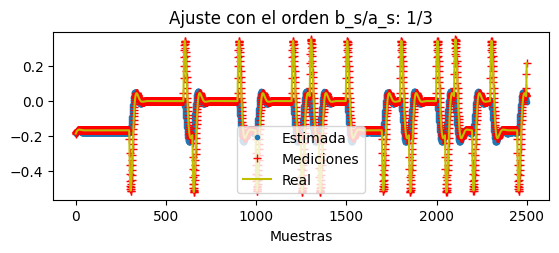

In [682]:
# Define the discrete transfer function sys_id
dend = np.concatenate(([1], c[:orden_a]))  # From c vector
numd = c[orden_a:]  # From c vector
sys_id = ctrl.TransferFunction(numd, dend, dt=ts)

# Generate input signal ue for the new transfer function
ue = np.sign(np.sin(2 * np.pi * 0.010 * t))  # New input signal

# Simulate the system response of sys_id
t_sal, y_sal = ctrl.forced_response(sys_id, T=t, U=ue)

# Simulate the system response of sys
t_D, y_D = ctrl.forced_response(sys, T=t, U=ue)

# Plot the results
hfig1 = plt.figure(1)
plt.subplot(2, 1, 1)
plt.plot(z, '.')
plt.plot(zo, '+r')
plt.plot(ys[off_set:off_set + Med], 'y')
plt.legend(['Estimada', 'Mediciones', 'Real'])
plt.title(f'Ajuste con el orden b_s/a_s: {orden_b}/{orden_a + 1}')
plt.xlabel('Muestras')

plt.show()

Text(0.5, 0, 'Tiempo. [Seg.]')

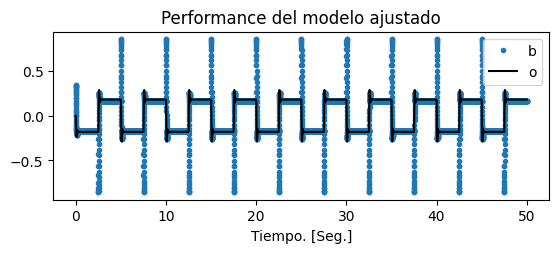

In [683]:
# Plot the results
plt.figure(1)
plt.subplot(2, 1, 2)
plt.plot(t_D * ts, y_D, '.')
plt.plot(t_sal * ts, y_sal, 'k')
plt.legend(['Real', 'Identificada'])
plt.legend('boxoff')
plt.title('Performance del modelo ajustado')
plt.xlabel('Tiempo. [Seg.]')

Text(0.5, 0, 'Tiempo. [Seg.]')

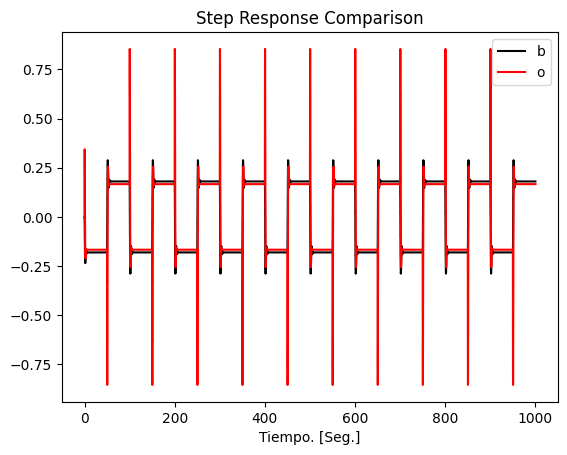

In [684]:
# Plot step response comparison
hfig2 = plt.figure(2)
plt.step(t, StepAmplitude * y_sal, 'k', label="Identificada")
plt.step(t, StepAmplitude * y_D, 'r', label="Real")
plt.legend(['Real', 'Identificada'])
plt.legend('boxoff')
plt.title('Step Response Comparison')
plt.xlabel('Tiempo. [Seg.]')

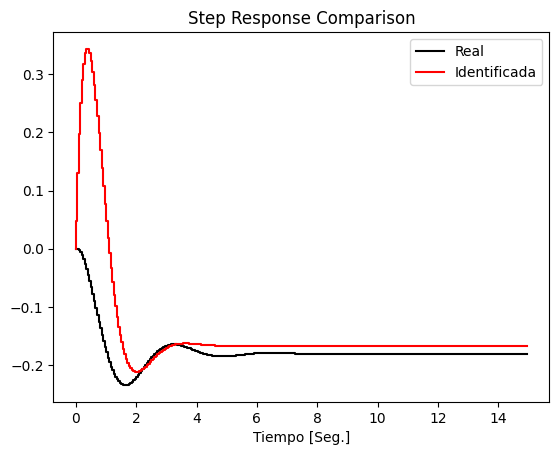

In [685]:
# Truncate first 100 values
t_truncated = t[:300]
y_sal_truncated = y_sal[:300]
y_D_truncated = y_D[:300]

# Plot step response comparison
hfig2 = plt.figure(2)
plt.step(t_truncated, StepAmplitude * y_sal_truncated, 'k', label="Identificada")
plt.step(t_truncated, StepAmplitude * y_D_truncated, 'r', label="Real")
plt.legend(['Real', 'Identificada'])
plt.title('Step Response Comparison')
plt.xlabel('Tiempo [Seg.]')
plt.show()


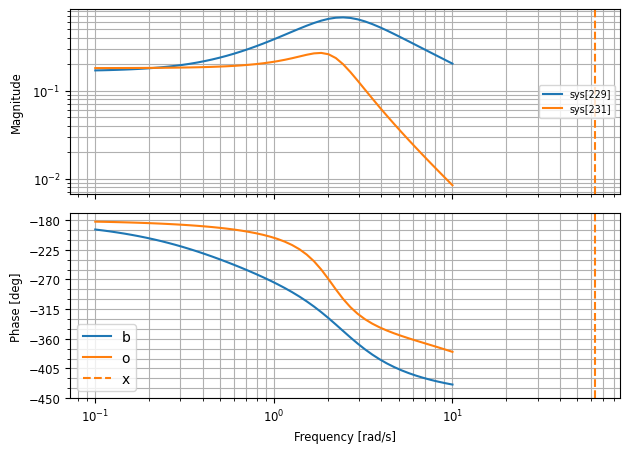

In [686]:
hfig3 = plt.figure(3)
ctrl.bode(sys, np.logspace(-1, 1))
ctrl.bode(sys_id, np.logspace(-1, 1))
plt.legend(['Original', 'Identificada'])
plt.legend('boxoff')

### Punto b

In [687]:
%reset -f

#### Determinación del orden

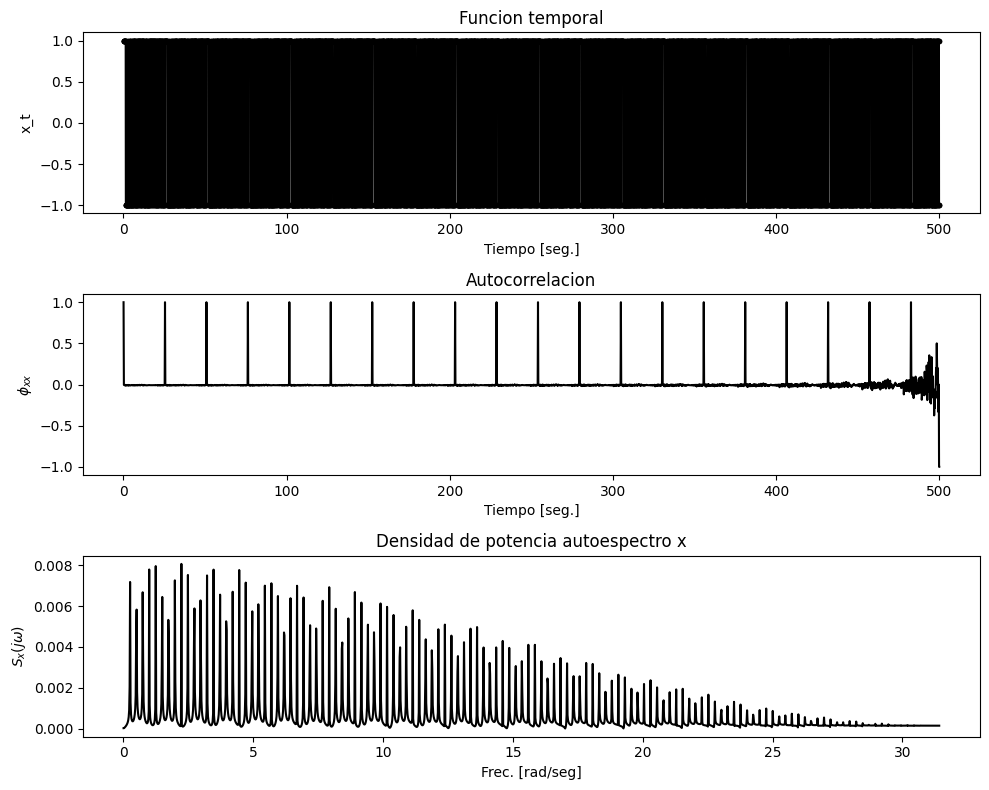

In [688]:
import numpy as np
import control as ctrl
from scipy.signal import dlti, dstep
import matplotlib.pyplot as plt

np.random.seed(10)

# Definición de la función de transferencia

num1 = [16]
num2 = [45,1]
num = np.convolve(num1,num2)
den1 = [25,1]
den2 = [30,1]
den = np.convolve(den1,den2)

sys_c = ctrl.TransferFunction(num, den)
# Discretización del sistema
ts = 1/10  # Tasa de muestreo
sys_d = ctrl.sample_system(sys_c, ts, method='zoh')
num_d = sys_d.num[0][0]
den_d = sys_d.den[0][0]
num_d = [0] + num_d  # Asegurar formato correcto

# Generación de PRBS
N = 5000
m = 7
e1, e2 = 6, m
x_seq = np.ones(m)
y = np.zeros(N)
el = 2
for k in range(0, N, el):
    n_b = np.bitwise_xor(int(x_seq[e2 - 1]), int(x_seq[e1 - 1]))
    y[k:k+el] = x_seq[6]
    x_seq[1:] = x_seq[:-1]
    x_seq[0] = n_b

x = 2 * y - 1

y = np.zeros_like(x)
Orn = len(den_d)
num_Orn = len(num_d) # order del numerador

for n in range(Orn, len(x)):
    y[n] = (np.dot(num_d[1:num_Orn], x[n-num_Orn+1:n][::-1]).T -
                np.dot(den_d[1:Orn], y[n-Orn+1:n][::-1])).T

Tmax = N * ts
t = np.arange(ts, Tmax + ts, ts)
W = N / (2 * Tmax)
fmax = 1 / (2 * ts)
Af = 2 * fmax / N
w1 = np.arange(0, fmax, Af)
w = 2 * np.pi * Af
# Autocorrelación de x
fixx = np.zeros(N)
fixx[0] = np.dot(x, x) / N

for j in range(1, N):
    fixx[j] = np.dot(x[:N-j], x[j:N]) / (N - j)

# Correlación cruzada xy
fixy = np.zeros(N)
fixy[0] = np.dot(x, y) / N

for j in range(1, N):
    fixy[j] = np.dot(x[:N-j], y[j:N]) / (N - j)
# Cálculo de la densidad espectral de potencia
M1 = int(0.7 * N)  # Intervalos de correlación útiles
j1 = np.arange(M1)
Sx = np.zeros(M1+1, dtype=complex)

Sx[0] = np.dot(fixx[:M1], np.exp(-1j * 2 * np.pi * 0 * j1 / M1))

for k in range(1, M1+1):
    Sx[k] = np.dot(fixx[:M1], np.exp(-1j * 2 * np.pi * k * j1 / M1))

Sx /= M1
Af = 2 * fmax / M1
w0 = np.arange(Af, fmax + Af, Af)
w0 = 2 * np.pi * w0

# Gráficos
plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
plt.plot(t[:len(x)], x, '.-k')
plt.title('Funcion temporal')
plt.xlabel('Tiempo [seg.]')
plt.ylabel('x_t')

plt.subplot(3, 1, 2)
plt.plot(t[:len(fixx)], fixx, 'k')
plt.title('Autocorrelacion')
plt.xlabel('Tiempo [seg.]')
plt.ylabel(r'$\phi_{xx}$')

plt.subplot(3, 1, 3)
plt.plot(w0[:M1//2], np.abs(Sx[:M1//2]), 'k')
plt.title('Densidad de potencia autoespectro x')
plt.xlabel('Frec. [rad/seg]')
plt.ylabel(r'$S_x(j\omega)$')
plt.tight_layout()
plt.show()

# Cálculo del interespéctro
Sxy = np.zeros(M1+1, dtype=complex)
Sxy[0] = np.dot(fixy[:M1], np.exp(-1j * np.pi * 0 * j1 / M1))

for k in range(1, M1+1):
    Sxy[k] = np.dot(fixy[:M1], np.exp(-1j * 2 * np.pi * k * j1 / M1))

Sxy /= M1

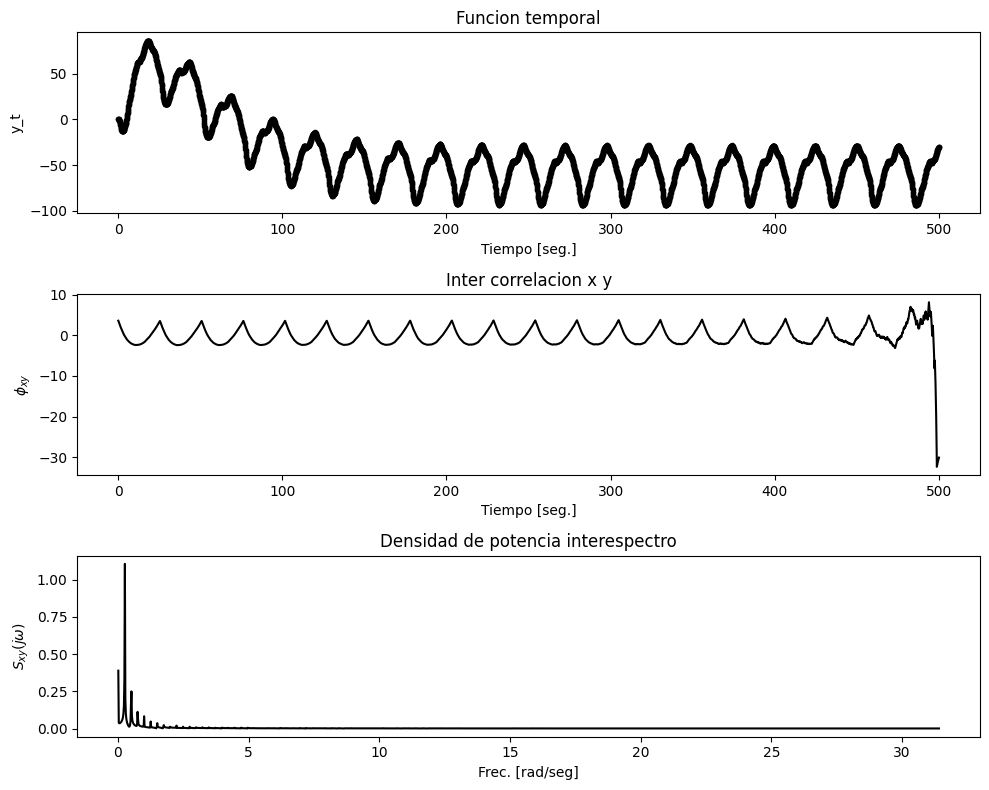

In [689]:
# Gráficos adicionales
plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
plt.plot(t[:len(y)], y, '.-k')
plt.title('Funcion temporal')
plt.xlabel('Tiempo [seg.]')
plt.ylabel('y_t')

plt.subplot(3, 1, 2)
plt.plot(t[:len(fixy)], fixy, 'k')
plt.title('Inter correlacion x y')
plt.xlabel('Tiempo [seg.]')
plt.ylabel(r'$\phi_{xy}$')

plt.subplot(3, 1, 3)
plt.plot(w0[:M1//2], np.abs(Sxy[:M1//2]), 'k')
plt.title('Densidad de potencia interespectro')
plt.xlabel('Frec. [rad/seg]')
plt.ylabel(r'$S_{xy}(j\omega)$')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/control/freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(


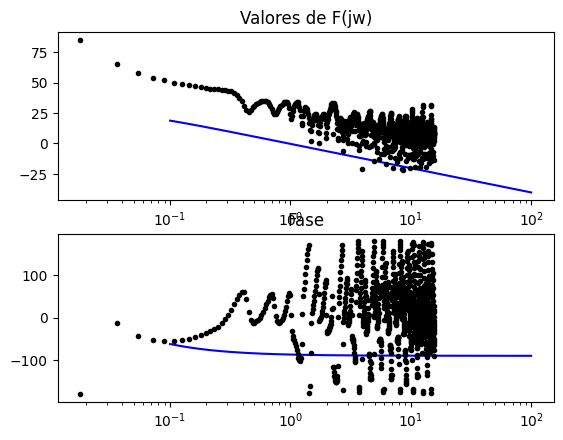

In [690]:
from control import tf, c2d, bode

# Define F_jw
F_jw = Sxy / Sx

# Bode y comparación
mag, phase, omega = bode(sys_c, omega_limits=[1e-1, 1e2], plot=False)
plt.figure()
plt.subplot(2, 1, 1)
plt.semilogx(omega, 20 * np.log10(mag), 'b')
plt.semilogx(w0[:M1//4], 20 * np.log10(np.abs(F_jw[:M1//4])), '.k')
plt.title('Valores de F(jw)')
plt.subplot(2, 1, 2)
plt.semilogx(omega, phase*180/np.pi, 'b')
plt.semilogx(w0[:M1//4], -180 * np.angle(F_jw[:M1//4]) / np.pi, '.k')
plt.title('Fase')
plt.savefig('Fig_20_4_3.png')

#### Identificación

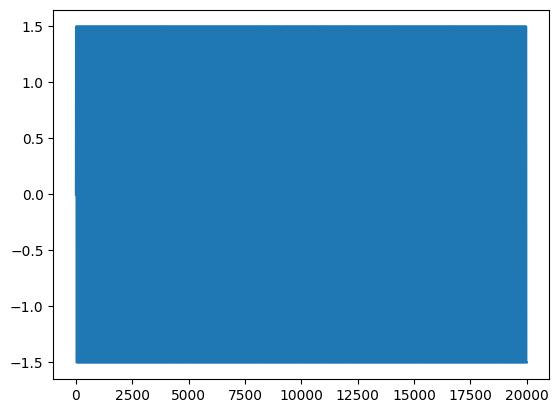

In [691]:
import numpy as np
import scipy.signal as signal
import control as ctrl
import matplotlib.pyplot as plt
from scipy.signal import dlti, dlsim, cont2discrete


# Configuración inicial
np.random.seed(10)
Med = 2500
ts = 1/10
orden_a = 2
orden_b = 1
num = [1]

t = np.arange(0, 20000 * ts, ts)
StepAmplitude = 1.5
ue = StepAmplitude * np.sign(np.sin(2 * np.pi * 0.2 * 1.0 * t))
plt.figure()
plt.plot(ue)

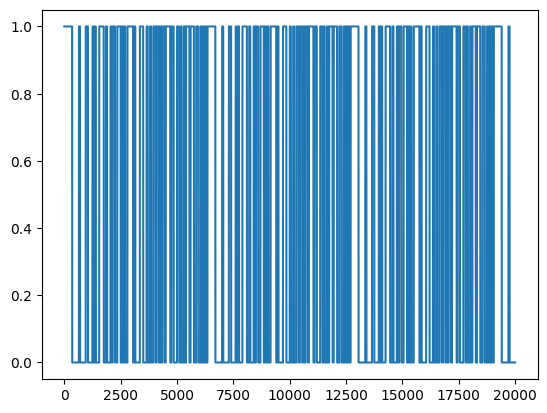

In [692]:
# Generación de PRBS
m = 7
x = np.ones(m)
N = len(ue)
el = 50
y = np.zeros(N)
for k in range(0, N, el):
    n_b = np.logical_xor(x[6], x[5])
    y[k:k+el] = x[6]
    x[1:m] = x[:m-1]
    x[0] = n_b
ue = y[:N]
plt.figure()
plt.plot(ue)

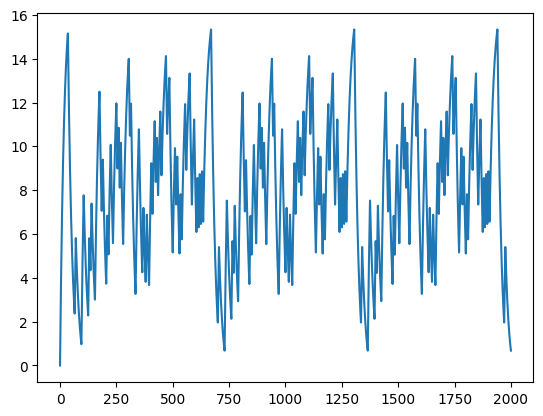

In [693]:
# Definición de la planta
num1 = [16]
num2 = [45,1]
num = np.convolve(num1,num2)
den1 = [25,1]
den2 = [30,1]
den = np.convolve(den1,den2)
sys = ctrl.TransferFunction(num, den)

t_out, y_D = ctrl.forced_response(sys, T=t, U=ue)
plt.figure()
plt.plot(t_out, y_D)

In [694]:
ys = y_D.T
# Ajuste por mínimos cuadrados
off_set = orden_a  + 1 + 50
u = ue[off_set:off_set+Med].T
z = ys[off_set:off_set+Med].T
zi = z.copy()

H = np.zeros((Med - orden_a, orden_a + orden_b))
for jj in range(orden_a, Med):
    vec_a = np.fliplr(np.array([np.concatenate([u[jj-orden_b:jj], -z[jj-orden_a:jj]])]))
    H[jj - orden_a, :] = vec_a.reshape(-1)

Z = z[orden_a:]
in_1 = H.T
in_2 = np.dot(in_1, H)
in_3 = np.linalg.inv(in_2)
in_4 = np.dot(in_3, in_1)
c = np.dot(in_4, Z)  # Ecuación 20-45
#vector de parametros optimo
c

array([-1.23280133,  0.23716268,  0.07317579])

In [695]:
# Ahora calculamos la salida estimada
zo = z.copy()
z = np.zeros(Med)
u = u.copy()

z[:orden_a] = zi[:orden_a]
u = ue[off_set:off_set + Med]

In [696]:
for k in range(orden_a, len(u)):
    zt = -np.flip(z[k - orden_a:k])
    ut = np.flip(u[k - orden_b:k])
    z[k] = np.dot(c.T, np.concatenate([zt, ut]))  # Ecuación 20-47

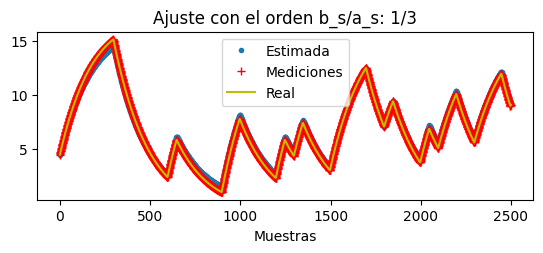

In [697]:
# definimos la función de transferencia del sistema identificado
dend = np.concatenate(([1], c[:orden_a]))  # From c vector
numd = c[orden_a:]  # From c vector
sys_id = ctrl.TransferFunction(numd, dend, dt=ts)

# Generamos la señal de entrada
ue = np.sign(np.sin(2 * np.pi * 0.010 * t))  # New input signal

# Simulamos respuesta del sistema idetificado
t_sal, y_sal = ctrl.forced_response(sys_id, T=t, U=ue)

# Simulamos respuesta del sistema
t_D, y_D = ctrl.forced_response(sys, T=t, U=ue)

# Resultados
hfig1 = plt.figure(1)
plt.subplot(2, 1, 1)
plt.plot(z, '.')
plt.plot(zo, '+r')
plt.plot(ys[off_set:off_set + Med], 'y')
plt.legend(['Estimada', 'Mediciones', 'Real'])
plt.title(f'Ajuste con el orden b_s/a_s: {orden_b}/{orden_a + 1}')
plt.xlabel('Muestras')

plt.show()

Text(0.5, 0, 'Tiempo. [Seg.]')

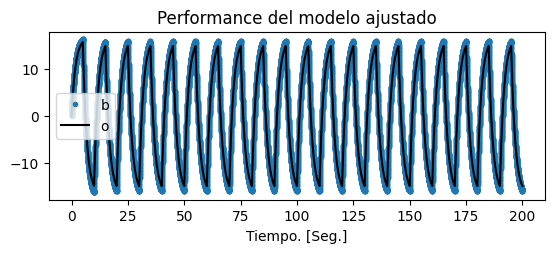

In [698]:
# Compración salidas de modelos
plt.figure(1)
plt.subplot(2, 1, 2)
plt.plot(t_D * ts, y_D, '.')
plt.plot(t_sal * ts, y_sal, 'k')
plt.legend(['Real', 'Identificada'])
plt.legend('boxoff')
plt.title('Performance del modelo ajustado')
plt.xlabel('Tiempo. [Seg.]')

Text(0.5, 0, 'Tiempo. [Seg.]')

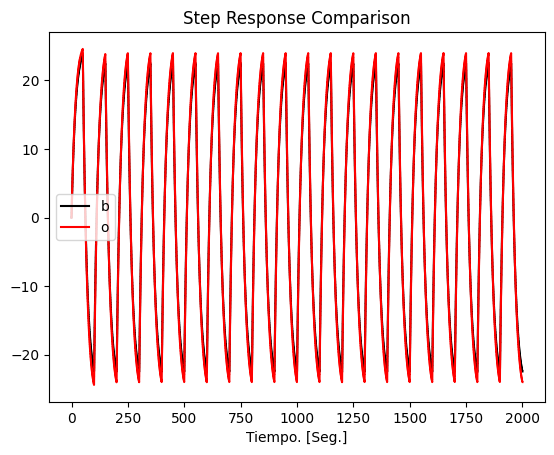

In [699]:
# Compración respuesta en escalon
hfig2 = plt.figure(2)
plt.step(t, StepAmplitude * y_sal, 'k', label="Identificada")
plt.step(t, StepAmplitude * y_D, 'r', label="Real")
plt.legend(['Real', 'Identificada'])
plt.legend('boxoff')
plt.title('Step Response Comparison')
plt.xlabel('Tiempo. [Seg.]')

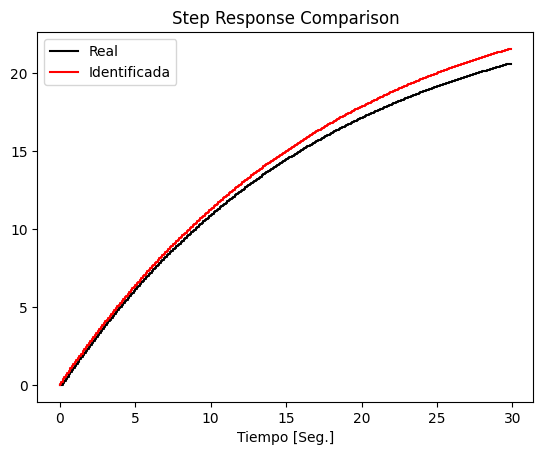

In [700]:
t_truncated = t[:300]
y_sal_truncated = y_sal[:300]
y_D_truncated = y_D[:300]

# Comparación de respuestas
hfig2 = plt.figure(2)
plt.step(t_truncated, StepAmplitude * y_sal_truncated, 'k', label="Identificada")
plt.step(t_truncated, StepAmplitude * y_D_truncated, 'r', label="Real")
plt.legend(['Real', 'Identificada'])
plt.title('Step Response Comparison')
plt.xlabel('Tiempo [Seg.]')
plt.show()


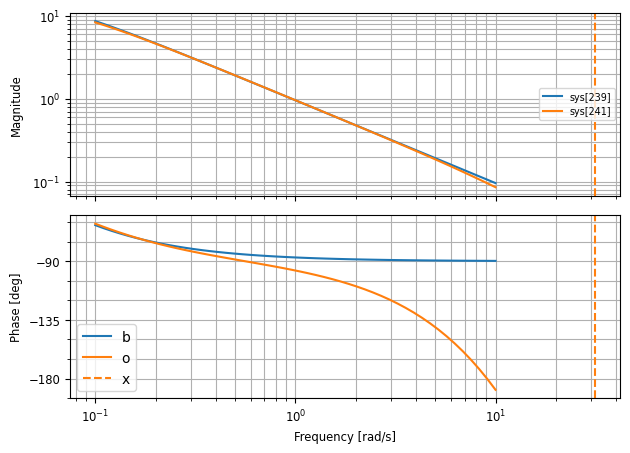

In [701]:
# Bode
hfig3 = plt.figure(3)
ctrl.bode(sys, np.logspace(-1, 1))
ctrl.bode(sys_id, np.logspace(-1, 1))
plt.legend(['Original', 'Identificada'])
plt.legend('boxoff')

# Problema 2

### Punto a

In [702]:
%reset -f

In [703]:
import control as ctl
from control import ss,c2d
import numpy as np

In [704]:
import control as ctrl

# Definimos la función de transferencia
numerator = [2, -1]  # 16(45s + 1)
denominator = [1, 3, 6]  # (25s + 1)(30s + 1)
# Obtener el sistema
system = ctrl.TransferFunction(numerator, denominator)

# Obtenemos las matrices
Mat_Ac, Mat_Bc, Mat_C, D = ctrl.ssdata(system)

print("Matrix A:")
print(Mat_Ac)
print("\nMatrix B:")
print(Mat_Bc)
print("\nMatrix C:")
print(Mat_C)

Matrix A:
[[-3. -6.]
 [ 1.  0.]]

Matrix B:
[[1.]
 [0.]]

Matrix C:
[[ 2. -1.]]


In [705]:
Ts = 0.005  # Tiempo de muestreo
T = 25     # Tiempo Total
Kmax = int(T / Ts)  # Numero de pasos

In [706]:
sys1 = ss(Mat_Ac, Mat_Bc, Mat_C, 0)

print(sys1)

<StateSpace>: sys[248]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (2): ['x[0]', 'x[1]']

A = [[-3. -6.]
     [ 1.  0.]]

B = [[1.]
     [0.]]

C = [[ 2. -1.]]

D = [[0.]]



In [707]:
# Convertimos a discreto usando un rententor de orden cero
dSys1 = c2d(sys1, Ts, method='zoh')

print(dSys1)

<StateSpace>: sys[248]$sampled
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (2): ['x[0]', 'x[1]']

A = [[ 0.98503769 -0.02977538]
     [ 0.00496256  0.99992537]]

B = [[4.96256273e-03]
     [1.24375784e-05]]

C = [[ 2. -1.]]

D = [[0.]]

dt = 0.005



In [708]:
# Matrices en tiempo discreto
A = dSys1.A
B = dSys1.B

print("Discrete-time A matrix:\n", A)
print("Discrete-time B matrix:\n", B)

Discrete-time A matrix:
 [[ 0.98503769 -0.02977538]
 [ 0.00496256  0.99992537]]
Discrete-time B matrix:
 [[4.96256273e-03]
 [1.24375784e-05]]


In [709]:
Cref = Mat_C[0, :]

# Construcción de matriz ampliada
Aamp1 = np.block([
    [A, np.zeros((2, 1))],
    [-np.dot(Cref, A), np.eye(1)]
])

print("Cref:\n", Cref)
print("Aamp1:\n", Aamp1)

Cref:
 [ 2. -1.]
Aamp1:
 [[ 0.98503769 -0.02977538  0.        ]
 [ 0.00496256  0.99992537  0.        ]
 [-1.96511281  1.05947613  1.        ]]


In [710]:
Bamp1 = np.vstack([B, -np.dot(Cref, B)])

print("Bamp1:\n", Bamp1)

Bamp1:
 [[ 4.96256273e-03]
 [ 1.24375784e-05]
 [-9.91268789e-03]]


In [711]:
Q1 = np.diag([1, 1, 1])

print("Q1:\n", Q1)

Q1:
 [[1 0 0]
 [0 1 0]
 [0 0 1]]


In [712]:
from control import dlqr

R1 = 500

# Matriz de Ganacia del LQR
K1, P1, _ = dlqr(Aamp1, Bamp1, Q1, R1)

print("K1:\n", K1)

K1:
 [[ 3.38188887 33.2288987   0.04434819]]


In [713]:
Kp1 = K1[0, :2]  # Proporcional
print("Kp1:\n", Kp1)

Kp1:
 [ 3.38188887 33.2288987 ]


In [714]:
Kint1 = -K1[0, 2] # Integrador
print("Kint:\n", Kint1)

Kint:
 -0.04434818970109311


In [715]:
# Matrices Observador
Ao = A.T
Bo = Mat_C.T
Co = B.T

Qo = np.diag([1, 1])
Ro = np.diag([1])

Ko, _, _ = dlqr(Ao, Bo, Qo, Ro)

Ko = Ko.T

print("Ko:\n", Ko)

Ko:
 [[ 0.23991401]
 [-0.39247686]]


In [716]:
KMAX = 5000

In [717]:
F_ = 0.1 * np.eye(2)  # Covarianza del ruido de estado
G_ = 0.1 * np.eye(1)  # Covarianza del ruido de medición

In [718]:
Realizaciones = 10
t = np.arange(0, KMAX * Ts, Ts)
x = np.array([[0], [0]])
ve = np.zeros(KMAX)
u_k = np.zeros((Realizaciones, KMAX))
y_sal = np.zeros((Realizaciones, KMAX))
y_sal_O = np.zeros((Realizaciones,KMAX))
xang = np.zeros((2, 1))
ref = 10

# Simulación
# Monte Carlo simulation
for trial in range(Realizaciones):
    # Random noise for process and measurement
    v = np.random.randn(2, KMAX)  # Process noise (4xkmax)
    w = np.random.randn(1, KMAX)  # Measurement noise (2xkmax)

    for ki in range(1, KMAX):
        ve[ki] = ve[ki - 1] + ref - Cref @ x
        u = -Kp1 @ xang + Kint1 * ve[ki]

        ys = Cref @ x  + G_ @ w[:, ki].reshape(-1, 1)
        x = A @ x + B * u + F_ @ v[:, ki].reshape(-1, 1)
        u_k[trial][ki] = u
        xang = A @ xang + B * u + Ko @ (ys - Mat_C @ xang)
        y_sal[trial][ki]= ys
        y_sal_O[trial][ki]= Mat_C @ xang

<ipython-input-718-c3aa6a897d47>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ve[ki] = ve[ki - 1] + ref - Cref @ x
<ipython-input-718-c3aa6a897d47>:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_k[trial][ki] = u
<ipython-input-718-c3aa6a897d47>:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_sal[trial][ki]= ys
<ipython-input-718-c3aa6a897d47>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in futu

In [719]:
t = t * Ts

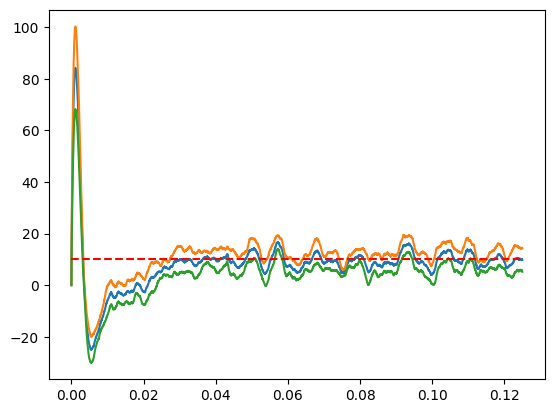

In [720]:
import matplotlib.pyplot as plt
# Salidad del sistema
plt.figure()
plt.plot(t, np.mean(y_sal, axis=0))
plt.plot(t, np.mean(y_sal, axis=0) + 0.5 * np.sqrt(np.var(y_sal, axis=0)))
plt.plot(t, np.mean(y_sal, axis=0) - 0.5 * np.sqrt(np.var(y_sal, axis=0)))
plt.hlines(ref, t[0], t[-1], linestyles='dashed', colors='r')

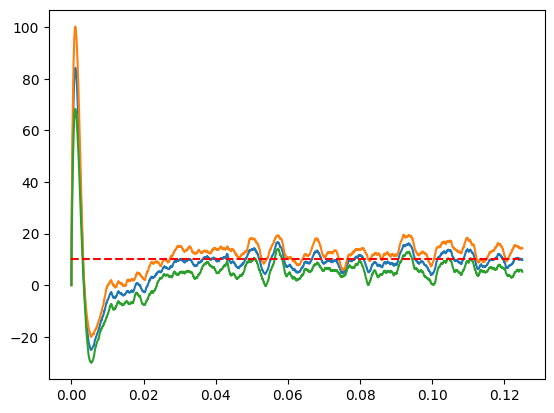

In [721]:
plt.figure()
# Salidad el observador
plt.plot(t, np.mean(y_sal_O, axis=0))
plt.plot(t, np.mean(y_sal_O, axis=0) + 0.5 * np.sqrt(np.var(y_sal_O, axis=0)))
plt.plot(t, np.mean(y_sal_O, axis=0) - 0.5 * np.sqrt(np.var(y_sal_O, axis=0)))
plt.hlines(ref, t[0], t[-1], linestyles='dashed', colors='r')

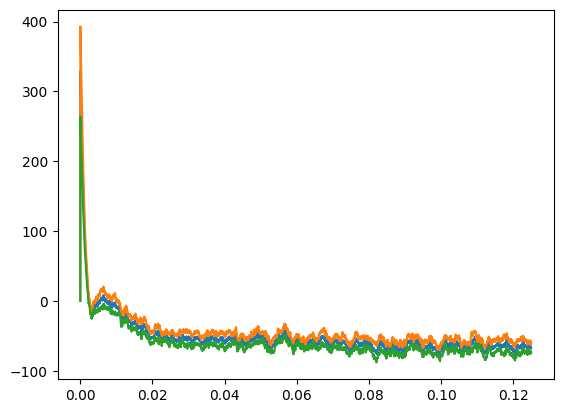

In [722]:
plt.figure()
# Accion de control
plt.plot(t, np.mean(u_k, axis=0))
plt.plot(t, np.mean(u_k, axis=0) + 0.5 * np.sqrt(np.var(u_k, axis=0)))
plt.plot(t, np.mean(u_k, axis=0) - 0.5 * np.sqrt(np.var(u_k, axis=0)))

### Punto b

In [723]:
%reset -f

In [724]:
import control as ctl
from control import ss,c2d
import numpy as np

In [725]:
import control as ctrl

# Definimos la función de transferencia
numerator = [16 * 45, 16]  # 16(45s + 1)
denominator = [25 * 30, 25 + 30, 1]  # (25s + 1)(30s + 1)
# Obtener el sistema
system = ctrl.TransferFunction(numerator, denominator)

# Obtenemos las matrices
Mat_Ac, Mat_Bc, Mat_C, D = ctrl.ssdata(system)

print("Matrix A:")
print(Mat_Ac)
print("\nMatrix B:")
print(Mat_Bc)
print("\nMatrix C:")
print(Mat_C)

Matrix A:
[[-0.07333333 -0.00133333]
 [ 1.          0.        ]]

Matrix B:
[[1.]
 [0.]]

Matrix C:
[[0.96       0.02133333]]


In [726]:
Ts = 0.01  # Tiempo de muestreo
T = 25     # Tiempo Total
Kmax = int(T / Ts)  # Numero de pasos

In [727]:
sys1 = ss(Mat_Ac, Mat_Bc, Mat_C, 0)

print(sys1)

<StateSpace>: sys[252]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (2): ['x[0]', 'x[1]']

A = [[-0.07333333 -0.00133333]
     [ 1.          0.        ]]

B = [[1.]
     [0.]]

C = [[0.96       0.02133333]]

D = [[0.]]



In [728]:
# Convertimos a discreto usando un rententor de orden cero
dSys1 = c2d(sys1, Ts, method='zoh')

print(dSys1)

<StateSpace>: sys[252]$sampled
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (2): ['x[0]', 'x[1]']

A = [[ 9.99266869e-01 -1.33284453e-05]
     [ 9.99633401e-03  9.99999933e-01]]

B = [[9.99633401e-03]
     [4.99877795e-05]]

C = [[0.96       0.02133333]]

D = [[0.]]

dt = 0.01



In [729]:
# Matrices en tiempo discreto
A = dSys1.A
B = dSys1.B

print("Discrete-time A matrix:\n", A)
print("Discrete-time B matrix:\n", B)

Discrete-time A matrix:
 [[ 9.99266869e-01 -1.33284453e-05]
 [ 9.99633401e-03  9.99999933e-01]]
Discrete-time B matrix:
 [[9.99633401e-03]
 [4.99877795e-05]]


In [730]:
Cref = Mat_C[0, :]

# Construcción de matriz ampliada
Aamp1 = np.block([
    [A, np.zeros((2, 1))],
    [-np.dot(Cref, A), np.eye(1)]
])

print("Cref:\n", Cref)
print("Aamp1:\n", Aamp1)

Cref:
 [0.96       0.02133333]
Aamp1:
 [[ 9.99266869e-01 -1.33284453e-05  0.00000000e+00]
 [ 9.99633401e-03  9.99999933e-01  0.00000000e+00]
 [-9.59509449e-01 -2.13205366e-02  1.00000000e+00]]


In [731]:
Bamp1 = np.vstack([B, -np.dot(Cref, B)])

print("Bamp1:\n", Bamp1)

Bamp1:
 [[ 9.99633401e-03]
 [ 4.99877795e-05]
 [-9.59754705e-03]]


In [732]:
Q1 = np.diag([1, 1, 1])

print("Q1:\n", Q1)

Q1:
 [[1 0 0]
 [0 1 0]
 [0 0 1]]


In [733]:
from control import dlqr

R1 = 1

# Matriz de Ganacia del LQR
K1, P1, _ = dlqr(Aamp1, Bamp1, Q1, R1)

print("K1:\n", K1)

K1:
 [[12.92802438  0.29193317 -0.93310607]]


In [734]:
Kp1 = K1[0, :2]  # Proporcional
print("Kp1:\n", Kp1)

Kp1:
 [12.92802438  0.29193317]


In [735]:
Kint1 = -K1[0, 2] # Integrador
print("Kint:\n", Kint1)

Kint:
 0.9331060737695025


In [736]:
# Matrices Observador
Ao = A.T
Bo = Mat_C.T
Co = B.T

Qo = np.diag([1, 1])
Ro = np.diag([1])

Ko, _, _ = dlqr(Ao, Bo, Qo, Ro)

Ko = Ko.T

print("Ko:\n", Ko)

Ko:
 [[0.62840126]
 [0.02158951]]


In [737]:
KMAX = 100

In [738]:
F_ = 0.1 * np.eye(2)  # Covarianza del ruido de estado
G_ = 0.1 * np.eye(1)  # Covarianza del ruido de medición

In [739]:
Realizaciones = 10
t = np.arange(0, KMAX * Ts, Ts)
x = np.array([[0], [0]])
ve = np.zeros(KMAX)
u_k = np.zeros((Realizaciones, KMAX))
y_sal = np.zeros((Realizaciones, KMAX))
y_sal_O = np.zeros((Realizaciones,KMAX))
xang = np.zeros((2, 1))
ref = 10

# Simulación
# Monte Carlo simulation
for trial in range(Realizaciones):
    # Random noise for process and measurement
    v = np.random.randn(2, KMAX)  # Process noise (4xkmax)
    w = np.random.randn(1, KMAX)  # Measurement noise (2xkmax)

    for ki in range(1, KMAX):
        ve[ki] = ve[ki - 1] + ref - Cref @ x
        u = -Kp1 @ xang + Kint1 * ve[ki]

        ys = Cref @ x  + G_ @ w[:, ki].reshape(-1, 1) # This should be measured y
        x = A @ x + B * u + F_ @ v[:, ki].reshape(-1, 1)
        u_k[trial][ki] = u
        xang = A @ xang + B * u + Ko @ (ys - Mat_C @ xang)
        y_sal[trial][ki]= ys
        y_sal_O[trial][ki]= Mat_C @ xang

<ipython-input-739-c3b279af3e7c>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ve[ki] = ve[ki - 1] + ref - Cref @ x
<ipython-input-739-c3b279af3e7c>:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_k[trial][ki] = u
<ipython-input-739-c3b279af3e7c>:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_sal[trial][ki]= ys
<ipython-input-739-c3b279af3e7c>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in futu

In [740]:
t = t * Ts

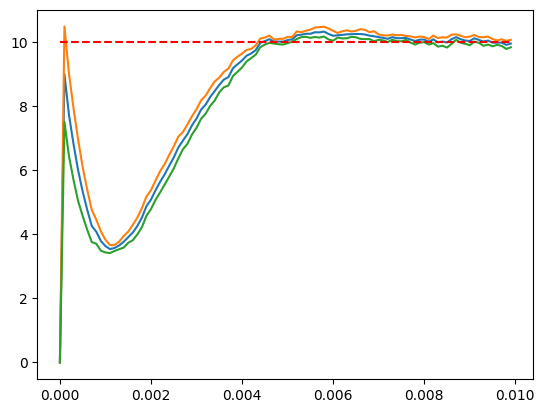

In [744]:
import matplotlib.pyplot as plt
# Salidad del sistema
plt.figure()
plt.plot(t, np.mean(y_sal, axis=0))
plt.plot(t, np.mean(y_sal, axis=0) + 0.5 * np.sqrt(np.var(y_sal, axis=0)))
plt.plot(t, np.mean(y_sal, axis=0) - 0.5 * np.sqrt(np.var(y_sal, axis=0)))
plt.hlines(ref, t[0], t[-1], linestyles='dashed', colors='r')

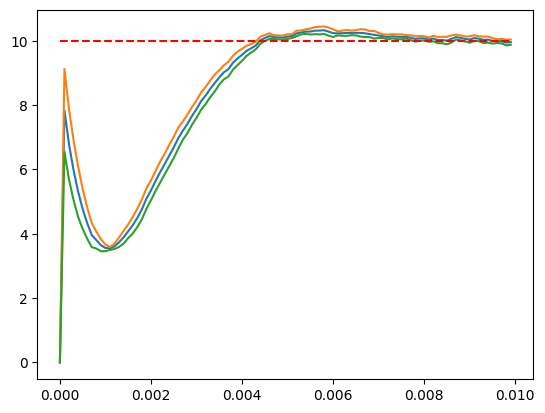

In [745]:
plt.figure()
# Salidad el observador
plt.plot(t, np.mean(y_sal_O, axis=0))
plt.plot(t, np.mean(y_sal_O, axis=0) + 0.5 * np.sqrt(np.var(y_sal_O, axis=0)))
plt.plot(t, np.mean(y_sal_O, axis=0) - 0.5 * np.sqrt(np.var(y_sal_O, axis=0)))
plt.hlines(ref, t[0], t[-1], linestyles='dashed', colors='r')

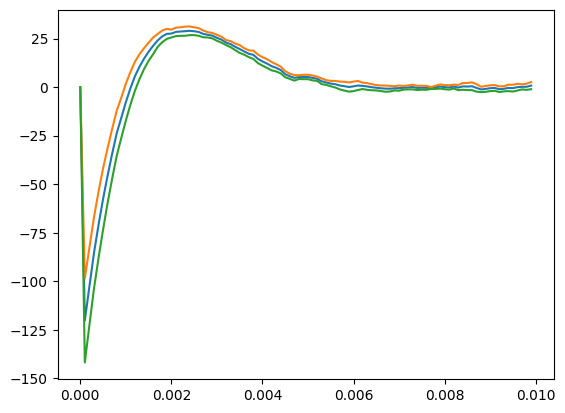

In [743]:
plt.figure()
# Accion de control
plt.plot(t, np.mean(u_k, axis=0))
plt.plot(t, np.mean(u_k, axis=0) + 0.5 * np.sqrt(np.var(u_k, axis=0)))
plt.plot(t, np.mean(u_k, axis=0) - 0.5 * np.sqrt(np.var(u_k, axis=0)))

# Problema 3

In [746]:
%reset -f

In [747]:
# Modelo del pendulo
def mopdm(tiempo_etapa, xant, accion):
    m = 0.1
    Fricc = 0.1
    long = 0.6
    g = 9.8
    M = 0.5
    tita_pp = 0
    h = 0.0001

    p, p_p, alfa, omega = xant

    for _ in range(int(tiempo_etapa / h)):
        p_pp = (1 / (M + m)) * (accion - m * long * tita_pp * np.cos(alfa) + m * long * omega**2 * np.sin(alfa) - Fricc * p_p)
        tita_pp = (1 / long) * (g * np.sin(alfa) - p_pp * np.cos(alfa))
        p_p += h * p_pp
        p += h * p_p
        omega += h * tita_pp
        alfa += h * omega

    return np.array([p, p_p, alfa, omega])

In [748]:
import numpy as np

# Parametros
m = 0.1
Fricc = 0.1
long = 0.6
g = 9.8
M = 0.5
TamanioFuente = 14

# condiciones iniciales
alfa = np.array([0.5])  # alfa(1)
color = '.b'
colorc = 'b'

Realizaciones = 5  # Realizaciones montecarlo

# Linearized version at the unstable equilibrium (Sontag Pp 104)
Mat_Ac = np.array([[0, 1, 0, 0],
                  [0, -Fricc/M, -m*g/M, 0],
                  [0, 0, 0, 1],
                  [0, Fricc/(long*M), g*(m+M)/(long*M), 0]])

Mat_Bc = np.array([0, 1/M, 0, -1/(long*M)]).reshape(-1, 1)

In [749]:
import control as ctrl

# Paramtros
kmax = 400 #pasos
sQ = 0.01
F_ = sQ * np.eye(4)  # Ruido de prealimentacion de estado
sR = 0.01  # Ruido de salida
G_ = sR * np.eye(2)
I = np.eye(4)

# Matrices del sistema
Mat_C = np.array([[1, 0, 0, 0],
                  [0, 0, 1, 0]])

# Espacio continuo
sys_c = ctrl.ss(Mat_Ac, Mat_Bc, Mat_C, 0)

# Tiempo de muestreo
Ts = 0.01

# Conversión a tiempo discreto
sys_d = ctrl.c2d(sys_c, Ts, method='zoh')
Mat_A = sys_d.A
Mat_B = sys_d.B

# Matriz de contrabilidad
Mat_M = np.hstack([Mat_B, np.dot(Mat_A, Mat_B), np.dot(Mat_A, np.dot(Mat_A, Mat_B)), np.dot(Mat_A, np.dot(Mat_A, np.dot(Mat_A, Mat_B)))])
rango = np.linalg.matrix_rank(Mat_M)

# Condiciones iniciales
x = np.array([0, 0, -alfa[0], 0])
x0 = x.copy()

# Variables de estado
p = np.zeros(kmax)
p_p = np.zeros(kmax)
alfa = np.zeros(kmax)
omega = np.zeros(kmax)

p[0] = x[0]
p_p[0] = x[1]
alfa[0] = x[2]
omega[0] = x[3]

# Asignamos matrices A y B
Aa = Mat_A
Ba = Mat_B

In [750]:
# Matriz P_Kalman inicial
P_Kalman = np.dot(F_, F_.T)

# Creamos los vectores
P11 = np.zeros(5000)
P22 = np.zeros(5000)
P33 = np.zeros(5000)
P44 = np.zeros(5000)

# Filtro de Kalman
for h_k in range(5000):
    P_Kalman_ = np.dot(np.dot(Mat_A, P_Kalman), Mat_A.T) + np.dot(F_, F_.T)
    K_Kalman = np.dot(np.dot(P_Kalman_, Mat_C.T), np.linalg.inv(np.dot(np.dot(Mat_C, P_Kalman_), Mat_C.T) + np.dot(G_, G_.T)))  # Ganancia de Kalman
    P_Kalman = np.dot((np.eye(4) - np.dot(K_Kalman, Mat_C)), P_Kalman_)

    # Completamos los vectores
    P11[h_k] = P_Kalman[0, 0]
    P22[h_k] = P_Kalman[1, 1]
    P33[h_k] = P_Kalman[2, 2]
    P44[h_k] = P_Kalman[3, 3]

In [751]:
import numpy as np

# Definimos el controlador DLQG
Q = 1e3 * np.diag([1e1, 1e1, 1e1, 1e1])
S = Q
P = S  # Condicion inicial para P
R = np.array(1e0)

# Creamos los vectores del K lqr y los autovalores
Kk = np.zeros((kmax, 4))
Ea = np.zeros((4, kmax))

# Itereamos para el diseño del controlador utilizando Ricatti
for hi in range(kmax-1, 0, -1):
    P = Q + np.dot(Aa.T, np.dot(P, Aa)) - np.dot(np.dot(Aa.T, np.dot(P, Ba)), np.linalg.inv(R + np.dot(Ba.T, np.dot(P, Ba)))) @ np.dot(Ba.T, np.dot(P, Aa))
    Kk[hi, :] = np.linalg.inv(R + np.dot(Ba.T, np.dot(P, Ba))) @ np.dot(Ba.T, P)

    Kk_reshaped = Kk[hi, :].reshape(1, -1)

    # Lazo cerrado
    A_cl = Aa - np.dot(Ba, Kk_reshaped)*Aa

    # Calculamos autovalores
    Ea[:, hi] = np.linalg.eigvals(A_cl)

In [752]:
from scipy.linalg import eig

# Contruimos la matrix H
block_matrix = np.linalg.inv(np.block([[np.eye(4), np.dot(Ba, R).dot(Ba.T)],
                                       [np.zeros((4, 4)), Aa]]))

H = np.dot(block_matrix, np.block([[Aa, np.zeros((4, 4))],
                                   [-Q, np.eye(4)]]))

# descomposición en autovalores
eigenvalues, eigenvectors = eig(H)

# Filtramos autovectore por autovalores
MX1X2 = []
for ii in range(len(eigenvalues)):
    if abs(eigenvalues[ii]) < 1:
        MX1X2.append(eigenvectors[:, ii])

MX1X2 = np.array(MX1X2).T

In [753]:
MX1 = MX1X2[:4, :]
MX2 = MX1X2[4:, :]

# Pa parte real
Pa = np.real(np.dot(MX2, np.linalg.inv(MX1)))

# LQR controlador
Klqr = np.linalg.inv(R + np.dot(Ba.T, np.dot(Pa, Ba))) @ np.dot(Ba.T, np.dot(Pa, Aa))

# Autovalores
Elqr = np.abs(np.linalg.eigvals(Aa - np.dot(Ba, Klqr)))

In [754]:
# Inicializamos variables de estado
p = np.zeros((Realizaciones, kmax))
p_p = np.zeros_like(p)
alfa = np.zeros_like(p)
omega = np.zeros_like(p)
y_sal = np.zeros_like(p)
y_sal_O = np.zeros_like(p)
Jn_ = np.zeros_like(p)
u = np.zeros_like(p)

x_hat = np.zeros_like(x0)
x_hat_ = np.zeros_like(x0)
t = np.arange(kmax) * Ts

# Simulación montecarlo
for trial in range(Realizaciones):
    v = np.random.randn(4, kmax)  # Ruido entrada
    w = np.random.randn(2, kmax)  # Ruido salida

    # Estado inicial
    p[trial, 0] = x0[0]
    p_p[trial, 0] = x0[1]
    alfa[trial, 0] = x0[2]
    omega[trial, 0] = x0[3]

    x = x0
    ua = 0
    for ki in range(kmax - 1):
        # Medicion de la salidad y filtro de kalman
        Y = np.dot(Mat_C, x) + np.dot(G_, w[:, ki])
        y_sal[trial, ki] = Y[0]
        y_diff = Y.reshape(-1,1) - np.dot(Mat_C, x_hat_).reshape(-1,1)
        # Actualización del estimador con ganancia de kalman
        x_hat = x_hat_.reshape(-1,1) + np.dot(K_Kalman, y_diff)
        # LQR control
        u[trial, ki] = -np.dot(Klqr, x_hat)

        # Actualizamos estado
        x = mopdm(Ts, x, u[trial, ki]) + np.dot(F_, v[:, ki])

        # Predicion de salida
        Y_O = np.dot(Mat_C, x_hat)
        y_sal_O[trial, ki] = Y_O[0]

        # Funcional de costo
        Jn_[trial, ki + 1] = Jn_[trial, ki] + (np.dot(x.T, np.dot(np.eye(4), x)) + np.dot(u[trial, ki].T, np.dot(np.ones_like(u[trial, ki]), u[trial, ki])))

        # actualizacion del estado apriori
        x_hat_ = np.dot(Mat_A, x_hat).reshape(-1,1) + np.dot(Mat_B, u[trial, ki])
        # Guardamos los valores de estado
        p[trial, ki + 1] = x[0]
        p_p[trial, ki + 1] = x[1]
        alfa[trial, ki + 1] = x[2]
        omega[trial, ki + 1] = x[3]

    Jn_[trial, ki + 1] = Jn_[trial, ki + 1] + np.dot(x.T, np.dot(np.eye(4), x))

<ipython-input-754-5dbbfe08f8b0>:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[trial, ki] = -np.dot(Klqr, x_hat)
<ipython-input-754-5dbbfe08f8b0>:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_sal_O[trial, ki] = Y_O[0]


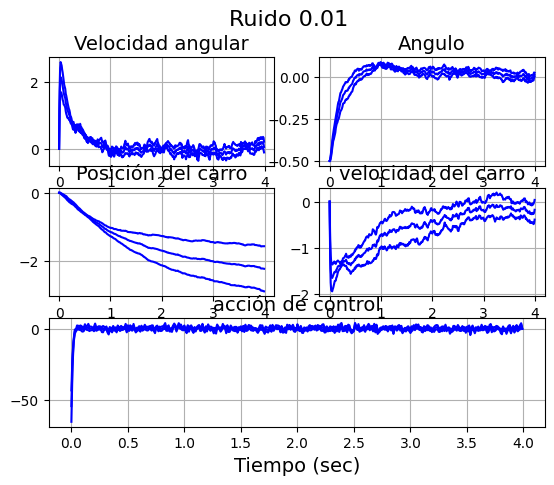

In [755]:
import matplotlib.pyplot as plt
mean_omega = np.mean(omega, axis=0)
std_omega = np.sqrt(np.var(omega, axis=0))
plt.suptitle('Ruido 0.01', fontsize=TamanioFuente + 2)  # Adjust font size as needed

plt.subplot(3, 2, 1)
plt.grid(True)
plt.title('Velocidad angular', fontsize=TamanioFuente)
plt.plot(t, mean_omega, color=colorc)
plt.plot(t, mean_omega + 0.5 * std_omega, color=colorc)
plt.plot(t, mean_omega - 0.5 * std_omega, color=colorc)

# Similarly for alfa, p, p_p, and u
mean_alfa = np.mean(alfa, axis=0)
std_alfa = np.sqrt(np.var(alfa, axis=0))

plt.subplot(3, 2, 2)
plt.grid(True)
plt.title('Angulo', fontsize=TamanioFuente)
plt.plot(t, mean_alfa, color=colorc)
plt.plot(t, mean_alfa + 0.5 * std_alfa, color=colorc)
plt.plot(t, mean_alfa - 0.5 * std_alfa, color=colorc)

mean_p = np.mean(p, axis=0)
std_p = np.sqrt(np.var(p, axis=0))

plt.subplot(3, 2, 3)
plt.grid(True)
plt.title('Posición del carro', fontsize=TamanioFuente)
plt.plot(t, mean_p, color=colorc)
plt.plot(t, mean_p + 0.5 * std_p, color=colorc)
plt.plot(t, mean_p - 0.5 * std_p, color=colorc)

mean_p_p = np.mean(p_p, axis=0)
std_p_p = np.sqrt(np.var(p_p, axis=0))

plt.subplot(3, 2, 4)
plt.grid(True)
plt.title('velocidad del carro', fontsize=TamanioFuente)
plt.plot(t, mean_p_p, color=colorc)
plt.plot(t, mean_p_p + 0.5 * std_p_p, color=colorc)
plt.plot(t, mean_p_p - 0.5 * std_p_p, color=colorc)

mean_u = np.mean(u, axis=0)
std_u = np.sqrt(np.var(u, axis=0))

plt.subplot(3, 1, 3)
plt.grid(True)
plt.title('acción de control', fontsize=TamanioFuente)
plt.xlabel('Tiempo (sec)', fontsize=TamanioFuente)
plt.plot(t, mean_u, color=colorc)
plt.plot(t, mean_u + 0.5 * std_u, color=colorc)
plt.plot(t, mean_u - 0.5 * std_u, color=colorc)
plt.show()

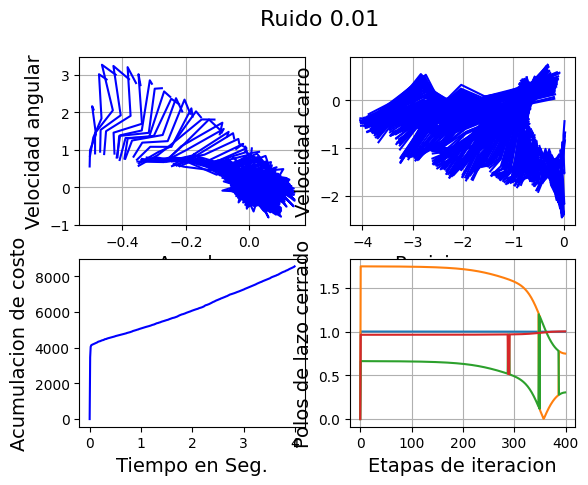

In [756]:

plt.suptitle('Ruido 0.01', fontsize=TamanioFuente + 2)
color='b'
plt.subplot(2, 2, 1)
plt.plot(alfa, omega, color=color)
plt.grid(True)
plt.xlabel('Angulo', fontsize=TamanioFuente)
plt.ylabel('Velocidad angular', fontsize=TamanioFuente)

plt.subplot(2, 2, 2)
plt.plot(p, p_p, color=color)
plt.grid(True)
plt.xlabel('Posicion carro', fontsize=TamanioFuente)
plt.ylabel('Velocidad carro', fontsize=TamanioFuente)


Jn = np.mean(Jn_,axis=0)
plt.subplot(2, 2, 3)
plt.plot(t, Jn, color=color)
plt.ylabel('Acumulacion de costo', fontsize=TamanioFuente)
plt.xlabel('Tiempo en Seg.', fontsize=TamanioFuente)

plt.subplot(2, 2, 4)
plt.plot(np.abs(Ea).T)
plt.grid(True)
plt.ylabel('Polos de lazo cerrado', fontsize=TamanioFuente)
plt.xlabel('Etapas de iteracion', fontsize=TamanioFuente)
plt.show()

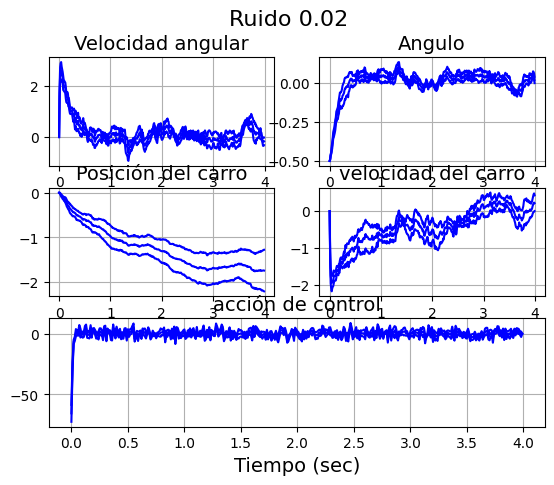

In [399]:
import matplotlib.pyplot as plt
mean_omega = np.mean(omega, axis=0)
std_omega = np.sqrt(np.var(omega, axis=0))
plt.suptitle('Ruido 0.02', fontsize=TamanioFuente + 2)  # Adjust font size as needed

plt.subplot(3, 2, 1)
plt.grid(True)
plt.title('Velocidad angular', fontsize=TamanioFuente)
plt.plot(t, mean_omega, color=colorc)
plt.plot(t, mean_omega + 0.5 * std_omega, color=colorc)
plt.plot(t, mean_omega - 0.5 * std_omega, color=colorc)

# Similarly for alfa, p, p_p, and u
mean_alfa = np.mean(alfa, axis=0)
std_alfa = np.sqrt(np.var(alfa, axis=0))

plt.subplot(3, 2, 2)
plt.grid(True)
plt.title('Angulo', fontsize=TamanioFuente)
plt.plot(t, mean_alfa, color=colorc)
plt.plot(t, mean_alfa + 0.5 * std_alfa, color=colorc)
plt.plot(t, mean_alfa - 0.5 * std_alfa, color=colorc)

mean_p = np.mean(p, axis=0)
std_p = np.sqrt(np.var(p, axis=0))

plt.subplot(3, 2, 3)
plt.grid(True)
plt.title('Posición del carro', fontsize=TamanioFuente)
plt.plot(t, mean_p, color=colorc)
plt.plot(t, mean_p + 0.5 * std_p, color=colorc)
plt.plot(t, mean_p - 0.5 * std_p, color=colorc)

mean_p_p = np.mean(p_p, axis=0)
std_p_p = np.sqrt(np.var(p_p, axis=0))

plt.subplot(3, 2, 4)
plt.grid(True)
plt.title('velocidad del carro', fontsize=TamanioFuente)
plt.plot(t, mean_p_p, color=colorc)
plt.plot(t, mean_p_p + 0.5 * std_p_p, color=colorc)
plt.plot(t, mean_p_p - 0.5 * std_p_p, color=colorc)

mean_u = np.mean(u, axis=0)
std_u = np.sqrt(np.var(u, axis=0))

plt.subplot(3, 1, 3)
plt.grid(True)
plt.title('acción de control', fontsize=TamanioFuente)
plt.xlabel('Tiempo (sec)', fontsize=TamanioFuente)
plt.plot(t, mean_u, color=colorc)
plt.plot(t, mean_u + 0.5 * std_u, color=colorc)
plt.plot(t, mean_u - 0.5 * std_u, color=colorc)
plt.show()

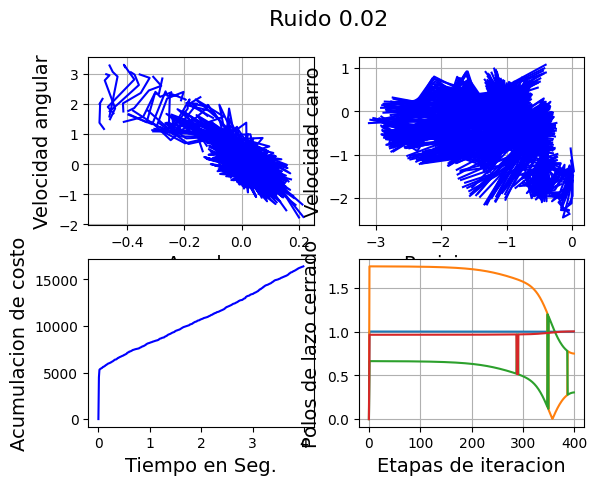

In [400]:

plt.suptitle('Ruido 0.02', fontsize=TamanioFuente + 2)
color='b'
plt.subplot(2, 2, 1)
plt.plot(alfa, omega, color=color)
plt.grid(True)
plt.xlabel('Angulo', fontsize=TamanioFuente)
plt.ylabel('Velocidad angular', fontsize=TamanioFuente)

plt.subplot(2, 2, 2)
plt.plot(p, p_p, color=color)
plt.grid(True)
plt.xlabel('Posicion carro', fontsize=TamanioFuente)
plt.ylabel('Velocidad carro', fontsize=TamanioFuente)


Jn = np.mean(Jn_,axis=0)
plt.subplot(2, 2, 3)
plt.plot(t, Jn, color=color)
plt.ylabel('Acumulacion de costo', fontsize=TamanioFuente)
plt.xlabel('Tiempo en Seg.', fontsize=TamanioFuente)

plt.subplot(2, 2, 4)
plt.plot(np.abs(Ea).T)
plt.grid(True)
plt.ylabel('Polos de lazo cerrado', fontsize=TamanioFuente)
plt.xlabel('Etapas de iteracion', fontsize=TamanioFuente)
plt.show()

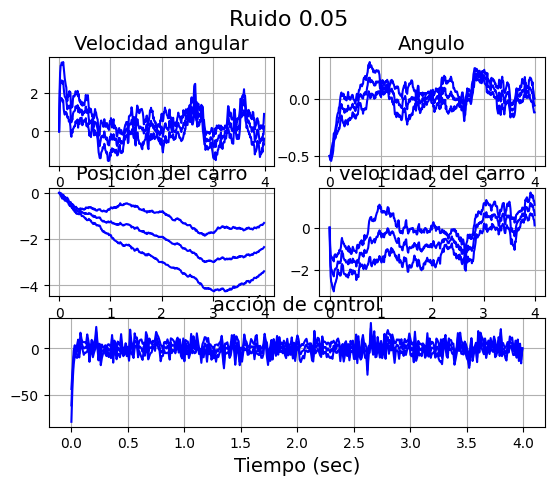

In [410]:
import matplotlib.pyplot as plt
mean_omega = np.mean(omega, axis=0)
std_omega = np.sqrt(np.var(omega, axis=0))
plt.suptitle('Ruido 0.05', fontsize=TamanioFuente + 2)

plt.subplot(3, 2, 1)
plt.grid(True)
plt.title('Velocidad angular', fontsize=TamanioFuente)
plt.plot(t, mean_omega, color=colorc)
plt.plot(t, mean_omega + 0.5 * std_omega, color=colorc)
plt.plot(t, mean_omega - 0.5 * std_omega, color=colorc)

# Similarly for alfa, p, p_p, and u
mean_alfa = np.mean(alfa, axis=0)
std_alfa = np.sqrt(np.var(alfa, axis=0))

plt.subplot(3, 2, 2)
plt.grid(True)
plt.title('Angulo', fontsize=TamanioFuente)
plt.plot(t, mean_alfa, color=colorc)
plt.plot(t, mean_alfa + 0.5 * std_alfa, color=colorc)
plt.plot(t, mean_alfa - 0.5 * std_alfa, color=colorc)

mean_p = np.mean(p, axis=0)
std_p = np.sqrt(np.var(p, axis=0))

plt.subplot(3, 2, 3)
plt.grid(True)
plt.title('Posición del carro', fontsize=TamanioFuente)
plt.plot(t, mean_p, color=colorc)
plt.plot(t, mean_p + 0.5 * std_p, color=colorc)
plt.plot(t, mean_p - 0.5 * std_p, color=colorc)

mean_p_p = np.mean(p_p, axis=0)
std_p_p = np.sqrt(np.var(p_p, axis=0))

plt.subplot(3, 2, 4)
plt.grid(True)
plt.title('velocidad del carro', fontsize=TamanioFuente)
plt.plot(t, mean_p_p, color=colorc)
plt.plot(t, mean_p_p + 0.5 * std_p_p, color=colorc)
plt.plot(t, mean_p_p - 0.5 * std_p_p, color=colorc)

mean_u = np.mean(u, axis=0)
std_u = np.sqrt(np.var(u, axis=0))

plt.subplot(3, 1, 3)
plt.grid(True)
plt.title('acción de control', fontsize=TamanioFuente)
plt.xlabel('Tiempo (sec)', fontsize=TamanioFuente)
plt.plot(t, mean_u, color=colorc)
plt.plot(t, mean_u + 0.5 * std_u, color=colorc)
plt.plot(t, mean_u - 0.5 * std_u, color=colorc)
plt.show()

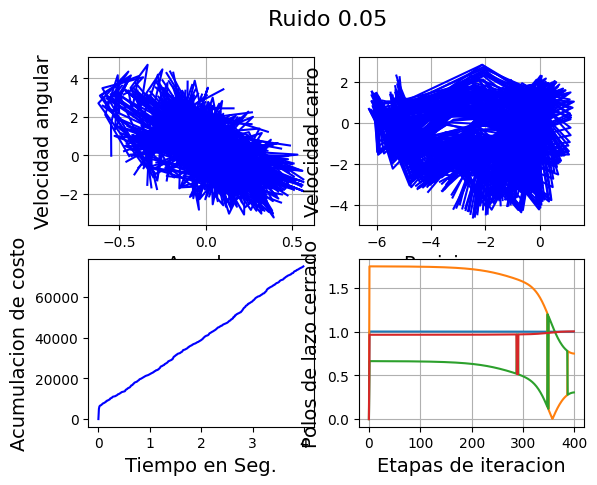

In [411]:

plt.suptitle('Ruido 0.05', fontsize=TamanioFuente + 2)
color='b'
plt.subplot(2, 2, 1)
plt.plot(alfa, omega, color=color)
plt.grid(True)
plt.xlabel('Angulo', fontsize=TamanioFuente)
plt.ylabel('Velocidad angular', fontsize=TamanioFuente)

plt.subplot(2, 2, 2)
plt.plot(p, p_p, color=color)
plt.grid(True)
plt.xlabel('Posicion carro', fontsize=TamanioFuente)
plt.ylabel('Velocidad carro', fontsize=TamanioFuente)


Jn = np.mean(Jn_,axis=0)
plt.subplot(2, 2, 3)
plt.plot(t, Jn, color=color)
plt.ylabel('Acumulacion de costo', fontsize=TamanioFuente)
plt.xlabel('Tiempo en Seg.', fontsize=TamanioFuente)

plt.subplot(2, 2, 4)
plt.plot(np.abs(Ea).T)
plt.grid(True)
plt.ylabel('Polos de lazo cerrado', fontsize=TamanioFuente)
plt.xlabel('Etapas de iteracion', fontsize=TamanioFuente)
plt.show()

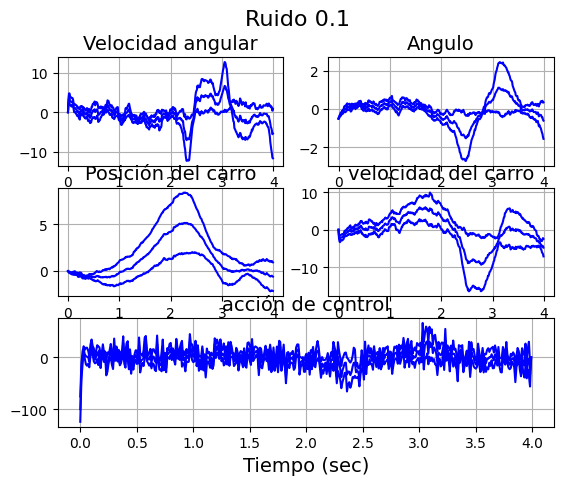

In [444]:
import matplotlib.pyplot as plt
mean_omega = np.mean(omega, axis=0)
std_omega = np.sqrt(np.var(omega, axis=0))
plt.suptitle('Ruido 0.1', fontsize=TamanioFuente + 2)

plt.subplot(3, 2, 1)
plt.grid(True)
plt.title('Velocidad angular', fontsize=TamanioFuente)
plt.plot(t, mean_omega, color=colorc)
plt.plot(t, mean_omega + 0.5 * std_omega, color=colorc)
plt.plot(t, mean_omega - 0.5 * std_omega, color=colorc)

# Similarly for alfa, p, p_p, and u
mean_alfa = np.mean(alfa, axis=0)
std_alfa = np.sqrt(np.var(alfa, axis=0))

plt.subplot(3, 2, 2)
plt.grid(True)
plt.title('Angulo', fontsize=TamanioFuente)
plt.plot(t, mean_alfa, color=colorc)
plt.plot(t, mean_alfa + 0.5 * std_alfa, color=colorc)
plt.plot(t, mean_alfa - 0.5 * std_alfa, color=colorc)

mean_p = np.mean(p, axis=0)
std_p = np.sqrt(np.var(p, axis=0))

plt.subplot(3, 2, 3)
plt.grid(True)
plt.title('Posición del carro', fontsize=TamanioFuente)
plt.plot(t, mean_p, color=colorc)
plt.plot(t, mean_p + 0.5 * std_p, color=colorc)
plt.plot(t, mean_p - 0.5 * std_p, color=colorc)

mean_p_p = np.mean(p_p, axis=0)
std_p_p = np.sqrt(np.var(p_p, axis=0))

plt.subplot(3, 2, 4)
plt.grid(True)
plt.title('velocidad del carro', fontsize=TamanioFuente)
plt.plot(t, mean_p_p, color=colorc)
plt.plot(t, mean_p_p + 0.5 * std_p_p, color=colorc)
plt.plot(t, mean_p_p - 0.5 * std_p_p, color=colorc)

mean_u = np.mean(u, axis=0)
std_u = np.sqrt(np.var(u, axis=0))

plt.subplot(3, 1, 3)
plt.grid(True)
plt.title('acción de control', fontsize=TamanioFuente)
plt.xlabel('Tiempo (sec)', fontsize=TamanioFuente)
plt.plot(t, mean_u, color=colorc)
plt.plot(t, mean_u + 0.5 * std_u, color=colorc)
plt.plot(t, mean_u - 0.5 * std_u, color=colorc)
plt.show()

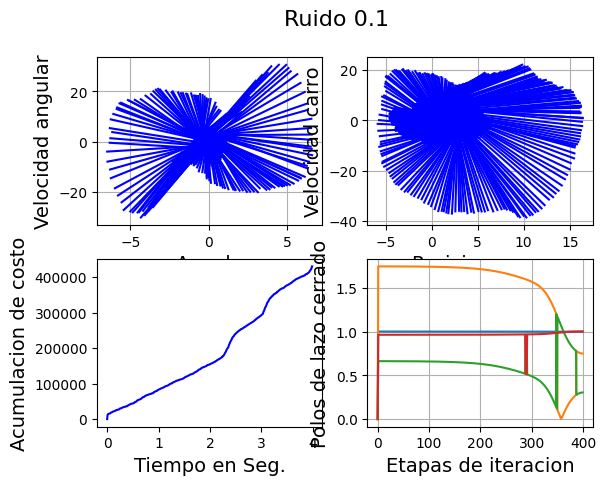

In [445]:

plt.suptitle('Ruido 0.1', fontsize=TamanioFuente + 2)
color='b'
plt.subplot(2, 2, 1)
plt.plot(alfa, omega, color=color)
plt.grid(True)
plt.xlabel('Angulo', fontsize=TamanioFuente)
plt.ylabel('Velocidad angular', fontsize=TamanioFuente)

plt.subplot(2, 2, 2)
plt.plot(p, p_p, color=color)
plt.grid(True)
plt.xlabel('Posicion carro', fontsize=TamanioFuente)
plt.ylabel('Velocidad carro', fontsize=TamanioFuente)


Jn = np.mean(Jn_,axis=0)
plt.subplot(2, 2, 3)
plt.plot(t, Jn, color=color)
plt.ylabel('Acumulacion de costo', fontsize=TamanioFuente)
plt.xlabel('Tiempo en Seg.', fontsize=TamanioFuente)

plt.subplot(2, 2, 4)
plt.plot(np.abs(Ea).T)
plt.grid(True)
plt.ylabel('Polos de lazo cerrado', fontsize=TamanioFuente)
plt.xlabel('Etapas de iteracion', fontsize=TamanioFuente)
plt.show()

### Conclusiones

Con ruido 0.01 el sistema tiene problemas de estabilidad. Se podría probar cambiando los valores de las matrices Q y R ademas de ajustar el tiempo de muestreo.